## BT4222 Group Project, Group 9

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile

### Read in and clean raw data from different sources
The code for reading and cleaning of data is referenced from kaggle source where all raw data was found.

In [3]:
#Information on passenger activity for airports and airlines
passengers = pd.read_csv('T3_AIR_CARRIER_SUMMARY_AIRPORT_ACTIVITY_2019.csv')
passengers

,OP_UNIQUE_CARRIER,CARRIER_NAME,ORIGIN_AIRPORT_ID,SERVICE_CLASS,REV_ACRFT_DEP_PERF_510,REV_PAX_ENP_110
0,04Q,Tradewind Aviation,15024,K,10.0,39.0
1,04Q,Tradewind Aviation,14843,K,677.0,3649.0
2,04Q,Tradewind Aviation,10257,V,4.0,6.0
3,04Q,Tradewind Aviation,15323,V,1.0,3.0
4,04Q,Tradewind Aviation,10158,V,1.0,2.0
...,...,...,...,...,...,...
27247,ZW,Air Wisconsin Airlines Corp,11637,K,122.0,4535.0
27248,ZW,Air Wisconsin Airlines Corp,11721,K,143.0,5800.0
27249,ZW,Air Wisconsin Airlines Corp,10469,K,248.0,8901.0
27250,ZW,Air Wisconsin Airlines Corp,12884,K,187.0,7923.0


In [4]:
#Manufacture year and passenger capacity for aircraft by unique aircraft tail number
aircraft = pd.read_csv("B43_AIRCRAFT_INVENTORY.csv",encoding='latin1')
aircraft.drop_duplicates(subset='TAIL_NUM', inplace=True)
aircraft

,MANUFACTURE_YEAR,TAIL_NUM,NUMBER_OF_SEATS
0,1944,N54514,0.0
1,1945,N1651M,0.0
2,1953,N100CE,0.0
3,1953,N141FL,0.0
4,1953,N151FL,0.0
...,...,...,...
7378,2019,N14011,337.0
7379,2019,N16008,337.0
7380,2019,N16009,337.0
7381,2019,N2250U,276.0


In [5]:
#Coordinates of airports
coords = pd.read_csv('AIRPORT_COORDINATES.csv')
coords.drop_duplicates(subset='ORIGIN_AIRPORT_ID', inplace=True)
coords

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,10001,Afognak Lake Airport,58.109444,-152.906667
1,10003,Bear Creek Mining Strip,65.548056,-161.071667
2,10004,Lik Mining Camp,68.083333,-163.166667
3,10005,Little Squaw Airport,67.570000,-148.183889
4,10006,Kizhuyak Bay,57.745278,-152.882778
...,...,...,...,...
18128,16908,Deer Park Airport,47.966944,-117.428611
18129,16909,South Texas International at Edinburg,26.441667,-98.122222
18130,16910,Louisa County Freeman Field,38.009722,-77.970000
18131,16911,Caldwell Industrial,43.641944,-116.635833


In [6]:
#Proper names of carriers for better EDA usage
names = pd.read_csv("CARRIER_DECODE.csv")
names.drop_duplicates(inplace=True)
names.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)
names

,AIRLINE_ID,OP_UNIQUE_CARRIER,CARRIER_NAME
0,21754,2PQ,21 Air LLC
3,20342,Q5,40-Mile Air
4,20342,WRB,40-Mile Air
6,19627,CIQ,A/S Conair
7,19072,AAE,AAA Airlines
...,...,...,...
2702,20379,ZKQ,Zantop International
2706,19771,ZAQ,Zas Airline Of Egypt
2707,21118,37,Zeal 320
2708,22069,ZG,ZIPAIR Tokyo Inc.


In [7]:
#Weather report for top 90% of airport cities, in 2019
weather_report = pd.read_csv('airport_weather_2019.csv')
weather_report

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WT08,WT09,WESD,WT10,PSUN,TSUN,SN32,SX32,TOBS,WT11
0,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/1/2019,4.70,NaN,0.14,0.0,0.0,64.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/2/2019,4.92,NaN,0.57,0.0,0.0,56.0,59.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/3/2019,5.37,NaN,0.15,0.0,0.0,52.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/4/2019,12.08,NaN,1.44,0.0,0.0,56.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00013874,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,1/5/2019,13.42,NaN,0.00,0.0,0.0,49.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38670,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-27,6.04,NaN,0.00,NaN,NaN,68.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38671,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-28,5.37,NaN,0.06,NaN,NaN,69.0,74.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38672,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-29,7.61,NaN,0.10,NaN,NaN,70.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38673,USW00093805,"TALLAHASSEE REGIONAL AIRPORT, FL US",2019-12-30,5.82,NaN,0.02,NaN,NaN,68.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Our list of cities and airports including the airport display name so that we can connect with our main df
cities = pd.read_csv('airports_list.csv')
cities

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"
1,10257,Albany International,"Albany, NY","ALBANY INTERNATIONAL AIRPORT, NY US"
2,10140,Albuquerque International Sunport,"Albuquerque, NM","ALBUQUERQUE INTERNATIONAL AIRPORT, NM US"
3,10299,Anchorage International,"Anchorage, AK","ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A..."
4,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
...,...,...,...,...
92,15370,Tulsa International,"Tulsa, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
93,12264,Washington Dulles International,"Washington, DC","WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US"
94,13851,Will Rogers World,"Oklahoma City, OK","OKLAHOMA CITY WILL ROGERS WORLD AIRPORT, OK US"
95,12191,William P Hobby,"Houston, TX","HOUSTON WILLIAM P HOBBY AIRPORT, TX US"


In [9]:
#Connect weather report with city names
weather_merge = pd.merge(cities, weather_report, how='left', on='NAME')
weather_merge.columns

Index(['ORIGIN_AIRPORT_ID', 'DISPLAY_AIRPORT_NAME', 'ORIGIN_CITY_NAME', 'NAME',
       'STATION', 'DATE', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03',
       'WT04', 'WT05', 'WT06', 'WT07', 'WT08', 'WT09', 'WESD', 'WT10', 'PSUN',
       'TSUN', 'SN32', 'SX32', 'TOBS', 'WT11'],
      dtype='object')

In [10]:
#Get only important metrics from the weather report (date, inches of precipitation, inches of snowfall, average temperature, average wind)
weather = weather_merge[['DATE', 'PRCP', 'SNOW', 'TAVG', 'AWND', 'ORIGIN_AIRPORT_ID']]

In [11]:
#Drop rows where no departure airport was recorded
weather.drop(weather.loc[weather['ORIGIN_AIRPORT_ID'].isna()].index, axis=0, inplace=True)

In [12]:
#Drop rows where no weather was recorded
weather.dropna(inplace=True)
weather

,DATE,PRCP,SNOW,TAVG,AWND,ORIGIN_AIRPORT_ID
365,2019-01-01,0.10,0.0,42.0,15.21,10257
366,2019-01-02,0.00,0.0,28.0,3.80,10257
367,2019-01-03,0.00,0.1,35.0,9.62,10257
368,2019-01-04,0.00,0.0,36.0,6.93,10257
369,2019-01-05,0.42,0.0,36.0,4.70,10257
...,...,...,...,...,...,...
35020,2019-12-27,0.00,0.0,32.0,5.82,10713
35021,2019-12-28,0.00,0.0,29.0,2.24,10713
35022,2019-12-29,0.04,0.1,31.0,6.26,10713
35023,2019-12-30,0.00,0.0,31.0,2.46,10713


In [13]:
#Cast data types to datetime to access the month and day of month to match up with main df
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['MONTH'] = pd.DatetimeIndex(weather['DATE']).month
weather['DAY_OF_MONTH'] = pd.DatetimeIndex(weather['DATE']).day
weather

,DATE,PRCP,SNOW,TAVG,AWND,ORIGIN_AIRPORT_ID,MONTH,DAY_OF_MONTH
365,2019-01-01,0.10,0.0,42.0,15.21,10257,1,1
366,2019-01-02,0.00,0.0,28.0,3.80,10257,1,2
367,2019-01-03,0.00,0.1,35.0,9.62,10257,1,3
368,2019-01-04,0.00,0.0,36.0,6.93,10257,1,4
369,2019-01-05,0.42,0.0,36.0,4.70,10257,1,5
...,...,...,...,...,...,...,...,...
35020,2019-12-27,0.00,0.0,32.0,5.82,10713,12,27
35021,2019-12-28,0.00,0.0,29.0,2.24,10713,12,28
35022,2019-12-29,0.04,0.1,31.0,6.26,10713,12,29
35023,2019-12-30,0.00,0.0,31.0,2.46,10713,12,30


In [14]:
def month_cleanup(monthly_data, aircraft, coords, names, weather):

    # drop rows with no departure time, tail number, or were cancelled
    print("Dropping NaNs from Dep Time, Tail Num. Dropping Cancellations.")
    monthly_data.drop(monthly_data.loc[monthly_data['DEP_TIME'].isna()].index, axis=0, inplace=True)
    monthly_data.drop(monthly_data.loc[monthly_data['TAIL_NUM'].isna()].index, axis=0, inplace=True)
    monthly_data.drop(monthly_data.loc[monthly_data['CANCELLED'].isna()].index, axis=0, inplace=True)
 
    # FEATURE ENGINEERING - SEGMENT NUMBER
    # list flight segment number for daily flight segments by tracking tail number
    print("Adding Flight Number Sequence - SEGMENT_NUMBER")
    monthly_data["SEGMENT_NUMBER"] = monthly_data.groupby(["TAIL_NUM", 'DAY_OF_MONTH'])["DEP_TIME"].rank("dense", ascending=True)
    
    # FEATURE ENGINEERING - CONCURRENT FLIGHTS
    # listing the number of concurrent flights at the airport in the time block 
    print("Adding Concurrent Flights - CONCURRENT_FLIGHTS")
    monthly_data['CONCURRENT_FLIGHTS'] = monthly_data.groupby(['ORIGIN_AIRPORT_ID','DAY_OF_MONTH', 'DEP_TIME_BLK'])['OP_UNIQUE_CARRIER'].transform("count")
 
    # MERGING to get NUMBER_OF_SEATS
    print("Applying seat counts to flights - NUMBER_OF_SEATS")   
    # merge aircraft info with main frame on tail number - get NUMBER_OF_SEATS 
    monthly_data = pd.merge(monthly_data, aircraft, how="left", on='TAIL_NUM')
    monthly_data['NUMBER_OF_SEATS'].dropna(inplace=True)

    # merge to get proper carrier name
    print("Applying Carrier Names - CARRIER_NAME")  
    monthly_data = pd.merge(monthly_data, names, how='left', on=['OP_UNIQUE_CARRIER'])
    
    # FEATURE ENGINEERING - AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH
    # add monthly flight statistics for carrier and airport
    print("Adding flight statistics for carrier and airport - AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH")
    monthly_data['AIRPORT_FLIGHTS_MONTH'] = monthly_data.groupby(['ORIGIN_AIRPORT_ID'])['ORIGIN_CITY_NAME'].transform('count')
    
    # FEATURE ENGINEERING - PLANE AGE
    # calculate age of plane
    print("Calculate Fleet Age - PLANE_AGE")
    monthly_data['MANUFACTURE_YEAR'].dropna(inplace=True)
    monthly_data['PLANE_AGE'] = 2019 - monthly_data['MANUFACTURE_YEAR']

    # merge to get airport coordinates
    print("Adding airport coordinates - LATITUDE, LONGITUDE, DEPARTING_AIRPORT")
    monthly_data = pd.merge(monthly_data, coords, how='left', on=['ORIGIN_AIRPORT_ID'])
    monthly_data['LATITUDE'] = round(monthly_data['LATITUDE'], 3)
    monthly_data['LONGITUDE'] = round(monthly_data['LONGITUDE'], 3)

    # FEATURE ENGINEERING - PREVIOUS AIRPORT
    # get previous airport for tail number
    print("Adding airports - PREVIOUS_AIRPORT")
    segment_temp = monthly_data[['DAY_OF_MONTH', 'TAIL_NUM', 'DISPLAY_AIRPORT_NAME', 'SEGMENT_NUMBER']]
    monthly_data = pd.merge_asof(monthly_data.sort_values('SEGMENT_NUMBER'), segment_temp.sort_values('SEGMENT_NUMBER'), on='SEGMENT_NUMBER', by=['DAY_OF_MONTH', 'TAIL_NUM'], allow_exact_matches=False)
    monthly_data['DISPLAY_AIRPORT_NAME_y'].fillna('NONE', inplace=True)
    monthly_data.rename(columns={"DISPLAY_AIRPORT_NAME_y": "PREVIOUS_AIRPORT", "DISPLAY_AIRPORT_NAME_x": "DEPARTING_AIRPORT"}, inplace=True)  
    
    # drop airports below the 10th percentile
    print("Dropping bottom 10% of airports")
    monthly_data.drop(monthly_data.loc[monthly_data['AIRPORT_FLIGHTS_MONTH'] < 1100].index, axis=0, inplace=True)

    # merge weather data
    print("Adding daily weather data - PRCP, SNOW, TAVG, AWND")
    monthly_data = pd.merge(monthly_data, weather, how='inner', on=['ORIGIN_AIRPORT_ID', 'MONTH', 'DAY_OF_MONTH'])

    # drop columns we won't use
    print("Clean up unneeded columns")
    monthly_data.drop(columns = ['ORIGIN',  'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME',
                                 'ARR_TIME', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME',
                                 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
                                 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ARR_DELAY_NEW',
                                 'Unnamed: 32', 'ARR_TIME_BLK', 'ACTUAL_ELAPSED_TIME',
                                 'DEST_AIRPORT_ID', 'DEST_CITY_NAME',  'OP_CARRIER_FL_NUM',
                                 'OP_UNIQUE_CARRIER', 'AIRLINE_ID', 'DATE', 'DAY_OF_MONTH',
                                 'TAIL_NUM','DEP_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME',
                                 'MANUFACTURE_YEAR'
                                 ],
                    axis=1, inplace=True)
    
    print("Cleaning up data types")
    monthly_data['MONTH'] = monthly_data['MONTH'].astype('object')
    monthly_data['DAY_OF_WEEK'] = monthly_data['DAY_OF_WEEK'].astype('object')
    monthly_data['DISTANCE'] = monthly_data['DISTANCE'].astype('int64')
    monthly_data['SEGMENT_NUMBER'] = monthly_data['SEGMENT_NUMBER'].astype('int8')
    monthly_data['AIRPORT_FLIGHTS_MONTH'] = monthly_data['AIRPORT_FLIGHTS_MONTH'].astype('int64')
    
    monthly_data.reset_index(inplace=True, drop=True)
    
    print("FINISHED")
    
    return monthly_data

#### All code from here on is not referenced from the kaggle source.

In [15]:
#Processing all files
files = ['ONTIME_REPORTING_01.csv', 'ONTIME_REPORTING_02.csv', 'ONTIME_REPORTING_03.csv',
         'ONTIME_REPORTING_04.csv', 'ONTIME_REPORTING_05.csv', 'ONTIME_REPORTING_06.csv',
         'ONTIME_REPORTING_07.csv', 'ONTIME_REPORTING_08.csv', 'ONTIME_REPORTING_09.csv',
         'ONTIME_REPORTING_10.csv', 'ONTIME_REPORTING_11.csv', 'ONTIME_REPORTING_12.csv']

month_df_list = []

for file in files:
    df = pd.read_csv(file)
    curr_month = month_cleanup(df, aircraft, coords, names, weather)
    month_df_list.append(curr_month)
    print("Processing done for file", file)
    print("\n")

Dropping NaNs from Dep Time, Tail Num. Dropping Cancellations.
Adding Flight Number Sequence - SEGMENT_NUMBER
Adding Concurrent Flights - CONCURRENT_FLIGHTS
Applying seat counts to flights - NUMBER_OF_SEATS
Applying Carrier Names - CARRIER_NAME
Adding flight statistics for carrier and airport - AIRPORT_FLIGHTS_MONTH, AIRLINE_FLIGHTS_MONTH, AIRLINE_AIRPORT_FLIGHTS_MONTH
Calculate Fleet Age - PLANE_AGE
Adding airport coordinates - LATITUDE, LONGITUDE, DEPARTING_AIRPORT
Adding airports - PREVIOUS_AIRPORT
Dropping bottom 10% of airports
Adding daily weather data - PRCP, SNOW, TAVG, AWND
Clean up unneeded columns
Cleaning up data types
FINISHED
Processing done for file ONTIME_REPORTING_01.csv


Dropping NaNs from Dep Time, Tail Num. Dropping Cancellations.
Adding Flight Number Sequence - SEGMENT_NUMBER
Adding Concurrent Flights - CONCURRENT_FLIGHTS
Applying seat counts to flights - NUMBER_OF_SEATS
Applying Carrier Names - CARRIER_NAME
Adding flight statistics for carrier and airport - AIRPO

In [16]:
#Combine all processed raw data to form the main df
combined_df = pd.DataFrame()
for df in month_df_list:
    combined_df = pd.concat([combined_df, df], axis=0)

### Re-assigning values in variables to our newly defined values

The new values are more meaningful and will help to avoid having too many unecessary values in each variable.

In [17]:
#Re-assign seasons
seasons = []
month = combined_df["MONTH"].to_list()

for num in range(len(combined_df.index)):
    if month[num] in [3, 4, 5]:
        seasons.append("Spring")
    elif month[num] in [6, 7, 8]:
        seasons.append("Summer")
    elif month[num] in [9, 10, 11]:
        seasons.append("Autumn")
    else:
        seasons.append("Winter")

combined_df["SEASON"] = seasons

In [18]:
#Re-assign time of week
time_of_week = []
day = combined_df["DAY_OF_WEEK"].to_list()

for num in range(len(combined_df.index)):
    if day[num] in [1, 2]:
        time_of_week.append("Start")
    elif day[num] in [3, 4]:
        time_of_week.append("Mid")
    else:
        time_of_week.append("Weekend")

combined_df["TIME_OF_WEEK"] = time_of_week 

In [19]:
#Re-assign time of day
combined_df["DEP_TIME_BLK"].unique()

early_morning = ["0001-0559"]
morning = ["0600-0659", "0700-0759", "0800-0859",
           "0900-0959", "1000-1059", "1100-1159"]
afternoon = ["1200-1259", "1300-1359", "1400-1459",
             "1500-1559", "1600-1659", "1700-1759"]
night = ["1800-1859", "1900-1959", "2000-2059",
         "2100-2159", "2200-2259", "2300-2359"]

time_of_day = []
block = combined_df["DEP_TIME_BLK"].to_list()

for num in range(len(combined_df.index)):
    if block[num] in early_morning:
        time_of_day.append("Early Morning")
    elif block[num] in morning:
        time_of_day.append("Morning")
    elif block[num] in afternoon:
        time_of_day.append("Afternoon")
    else:
        time_of_day.append("Night")

combined_df["TIME_OF_DAY"] = time_of_day

In [20]:
#Encoding the target variable
delay_cancellation_cat = []
cancelled = combined_df["CANCELLED"].to_list()
delay_durat = combined_df["DEP_DELAY_NEW"].to_list()

for num in range(len(combined_df.index)):
    if cancelled[num] == 1:
        delay_cancellation_cat.append(4)
    else:                
        if delay_durat[num] > 45:
            delay_cancellation_cat.append(3)
        elif delay_durat[num] > 15:
            delay_cancellation_cat.append(2)
        elif delay_durat[num] > 0:
            delay_cancellation_cat.append(1)
        else:
            delay_cancellation_cat.append(0)

combined_df["DELAY_CAT"] = delay_cancellation_cat

In [21]:
#Drop unused columns
combined_df.drop(["DEP_DEL15", "SEGMENT_NUMBER", "AIRPORT_FLIGHTS_MONTH", "LATITUDE", "LONGITUDE", "PREVIOUS_AIRPORT"], axis=1, inplace=True)

In [22]:
#Drop rows with missing data
combined_df.dropna(inplace=True)

In [23]:
combined_df

,MONTH,DAY_OF_WEEK,DEP_DELAY_NEW,DEP_TIME_BLK,CANCELLED,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,PLANE_AGE,DEPARTING_AIRPORT,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY,DELAY_CAT
0,1,1,241.0,2100-2159,0.0,719,18,173.0,United Air Lines Inc.,5.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Night,3
2,1,1,43.0,0700-0759,0.0,1514,35,216.0,United Air Lines Inc.,16.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,2
3,1,1,20.0,1000-1059,0.0,888,36,216.0,United Air Lines Inc.,15.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,2
4,1,1,40.0,0700-0759,0.0,2072,35,173.0,United Air Lines Inc.,6.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,2
5,1,1,0.0,0600-0659,0.0,1846,23,173.0,United Air Lines Inc.,6.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342049,12,6,15.0,1800-1859,0.0,1444,9,143.0,Southwest Airlines Co.,14.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Night,1
342050,12,6,50.0,1600-1659,0.0,990,11,143.0,Southwest Airlines Co.,18.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Afternoon,3
342051,12,6,0.0,1900-1959,0.0,825,16,143.0,Southwest Airlines Co.,19.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Night,0
342052,12,6,18.0,2000-2059,0.0,349,5,143.0,Southwest Airlines Co.,19.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Night,2


### Exploratory Data Analysis

In [24]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4005685 entries, 0 to 342053
Data columns (total 19 columns):
 #   Column              Dtype  
---  ------              -----  
 0   MONTH               object 
 1   DAY_OF_WEEK         object 
 2   DEP_DELAY_NEW       float64
 3   DEP_TIME_BLK        object 
 4   CANCELLED           float64
 5   DISTANCE            int64  
 6   CONCURRENT_FLIGHTS  int64  
 7   NUMBER_OF_SEATS     float64
 8   CARRIER_NAME        object 
 9   PLANE_AGE           float64
 10  DEPARTING_AIRPORT   object 
 11  PRCP                float64
 12  SNOW                float64
 13  TAVG                float64
 14  AWND                float64
 15  SEASON              object 
 16  TIME_OF_WEEK        object 
 17  TIME_OF_DAY         object 
 18  DELAY_CAT           int64  
dtypes: float64(8), int64(3), object(8)
memory usage: 611.2+ MB


In [25]:
combined_df.isnull().sum() 

MONTH                 0
DAY_OF_WEEK           0
DEP_DELAY_NEW         0
DEP_TIME_BLK          0
CANCELLED             0
DISTANCE              0
CONCURRENT_FLIGHTS    0
NUMBER_OF_SEATS       0
CARRIER_NAME          0
PLANE_AGE             0
DEPARTING_AIRPORT     0
PRCP                  0
SNOW                  0
TAVG                  0
AWND                  0
SEASON                0
TIME_OF_WEEK          0
TIME_OF_DAY           0
DELAY_CAT             0
dtype: int64

In [26]:
combined_df['DELAY_CAT'].value_counts()

0    2587281
1     680422
2     382246
3     352840
4       2896
Name: DELAY_CAT, dtype: int64

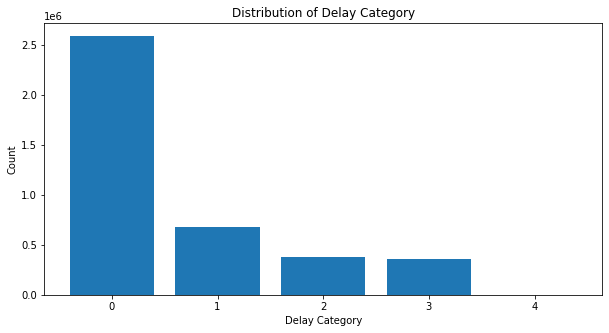

In [27]:
plt.figure(figsize=(10,5))
plt.bar(combined_df['DELAY_CAT'].value_counts().index, combined_df['DELAY_CAT'].value_counts().values)
plt.xlabel('Delay Category')
plt.ylabel('Count')
plt.title('Distribution of Delay Category')
plt.show()

In [28]:
combined_df['DEPARTING_AIRPORT'].value_counts()

Atlanta Municipal                 368562
Chicago O'Hare International      308296
Stapleton International           246416
Douglas Municipal                 229265
LaGuardia                         165326
                                   ...  
Honolulu International              4044
Portland International Jetport      3426
Spokane International               3413
Ontario International               1699
Long Beach Daugherty Field          1296
Name: DEPARTING_AIRPORT, Length: 63, dtype: int64

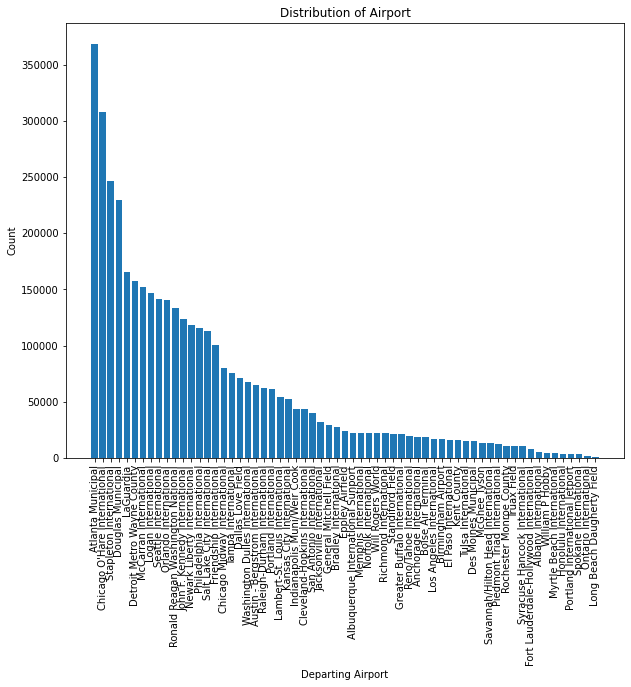

In [29]:
plt.figure(figsize=(10,8))
plt.bar(combined_df['DEPARTING_AIRPORT'].value_counts().index, combined_df['DEPARTING_AIRPORT'].value_counts().values)
plt.xlabel('Departing Airport')
plt.ylabel('Count')
plt.title('Distribution of Airport')
plt.xticks(rotation=90)
plt.show()

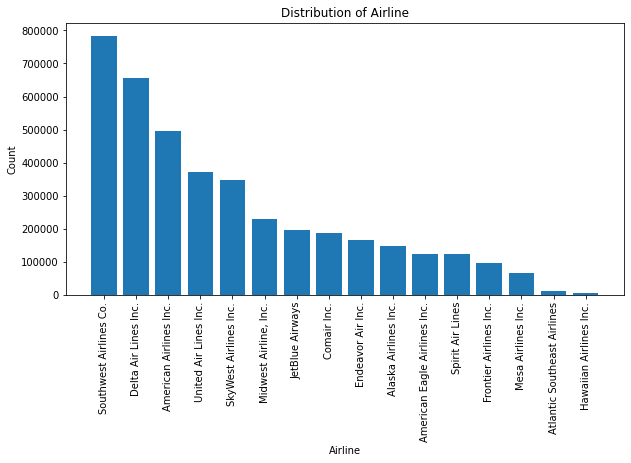

In [30]:
plt.figure(figsize=(10,5))
plt.bar(combined_df['CARRIER_NAME'].value_counts().index, combined_df['CARRIER_NAME'].value_counts().values)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Distribution of Airline')
plt.xticks(rotation=90)
plt.show()

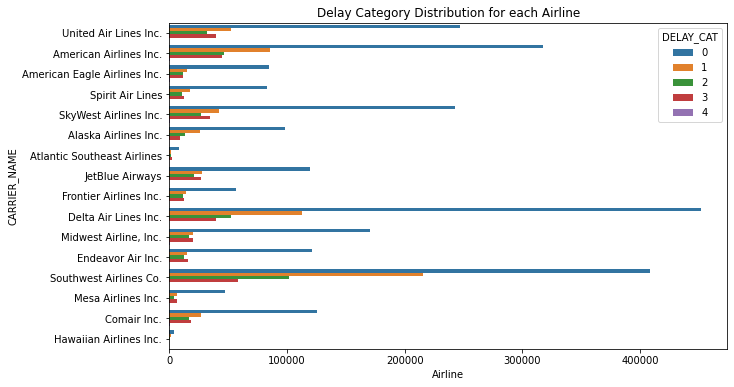

In [31]:
plt.figure(figsize=(10,6))
sns.countplot(y=combined_df['CARRIER_NAME'], hue=combined_df['DELAY_CAT'])
plt.title('Delay Category Distribution for each Airline')
plt.xlabel('Airline')
plt.show()

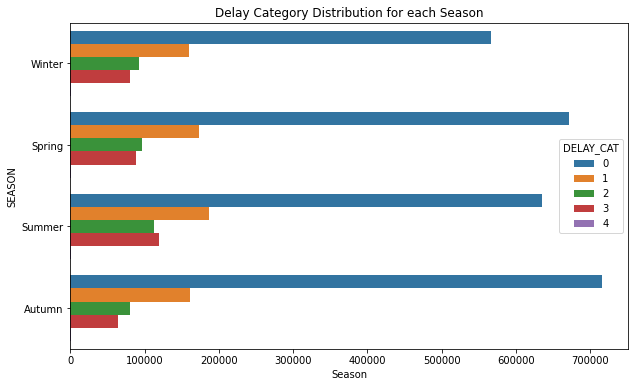

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(y=combined_df['SEASON'], hue=combined_df['DELAY_CAT'])
plt.title('Delay Category Distribution for each Season')
plt.xlabel('Season')
plt.show()

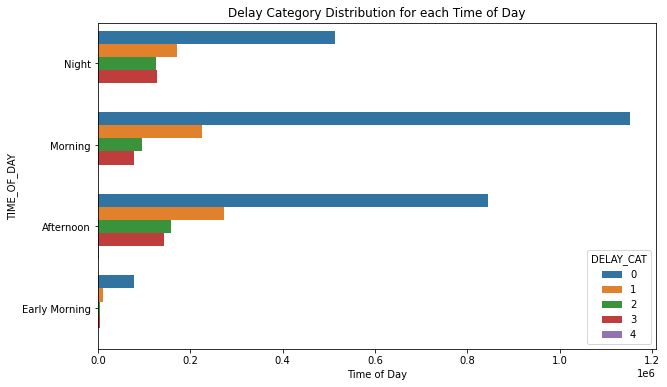

In [33]:
plt.figure(figsize=(10,6))
sns.countplot(y=combined_df['TIME_OF_DAY'], hue=combined_df['DELAY_CAT'])
plt.title('Delay Category Distribution for each Time of Day')
plt.xlabel('Time of Day')
plt.show()

### Undersampling
Undersample based on the categories in the target variable to get a balanced dataset

In [34]:
combined_df

,MONTH,DAY_OF_WEEK,DEP_DELAY_NEW,DEP_TIME_BLK,CANCELLED,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,PLANE_AGE,DEPARTING_AIRPORT,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY,DELAY_CAT
0,1,1,241.0,2100-2159,0.0,719,18,173.0,United Air Lines Inc.,5.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Night,3
2,1,1,43.0,0700-0759,0.0,1514,35,216.0,United Air Lines Inc.,16.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,2
3,1,1,20.0,1000-1059,0.0,888,36,216.0,United Air Lines Inc.,15.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,2
4,1,1,40.0,0700-0759,0.0,2072,35,173.0,United Air Lines Inc.,6.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,2
5,1,1,0.0,0600-0659,0.0,1846,23,173.0,United Air Lines Inc.,6.0,Chicago O'Hare International,0.53,5.0,18.0,12.75,Winter,Start,Morning,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342049,12,6,15.0,1800-1859,0.0,1444,9,143.0,Southwest Airlines Co.,14.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Night,1
342050,12,6,50.0,1600-1659,0.0,990,11,143.0,Southwest Airlines Co.,18.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Afternoon,3
342051,12,6,0.0,1900-1959,0.0,825,16,143.0,Southwest Airlines Co.,19.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Night,0
342052,12,6,18.0,2000-2059,0.0,349,5,143.0,Southwest Airlines Co.,19.0,Chicago Midway International,0.00,0.0,33.0,9.40,Winter,Weekend,Night,2


In [35]:
#Create individual dataframes for each category of the target variable
unique_cat = np.sort(combined_df['DELAY_CAT'].unique()) 
df_list = [] # index position corresponds to the target variable label

for cat in unique_cat:
    df = pd.DataFrame(combined_df.loc[combined_df['DELAY_CAT'] == cat])
    df_list.append(df)

In [36]:
#Python's random library is used to randomly undersample the data
new_df_list = []

for df in df_list:
    curr_list = []

    df_length = len(df.index)
    deck = list(range(df_length))
    
    random.shuffle(deck)
    for num in range(2896):
        curr_list.append(deck.pop())

    new_df = pd.DataFrame()
    for idx in curr_list:
        new_df = pd.concat([new_df, df.iloc[[idx]]], axis=0)
    new_df_list.append(new_df)

In [37]:
#Join all the undersampled df together
combined_final_df = pd.DataFrame()

for new_df in new_df_list:
    combined_final_df = pd.concat([combined_final_df, new_df], axis=0)

combined_final_df

,MONTH,DAY_OF_WEEK,DEP_DELAY_NEW,DEP_TIME_BLK,CANCELLED,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,PLANE_AGE,DEPARTING_AIRPORT,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY,DELAY_CAT
110002,8,1,0.0,0900-0959,0.0,1005,58,160.0,American Airlines Inc.,8.0,Chicago O'Hare International,0.00,0.0,79.0,8.28,Summer,Start,Morning,0
35579,12,1,0.0,1000-1059,0.0,814,28,70.0,Comair Inc.,17.0,Philadelphia International,0.38,0.0,36.0,6.49,Winter,Start,Morning,0
319697,8,1,0.0,2000-2059,0.0,369,17,143.0,Southwest Airlines Co.,8.0,Friendship International,0.00,0.0,84.0,5.14,Summer,Start,Night,0
322282,8,1,0.0,0700-0759,0.0,851,9,76.0,Mesa Airlines Inc.,2.0,Savannah/Hilton Head International,0.28,0.0,78.0,4.70,Summer,Start,Morning,0
225937,9,3,0.0,0600-0659,0.0,1011,16,142.0,United Air Lines Inc.,17.0,Tampa International,0.00,0.0,83.0,11.86,Autumn,Mid,Morning,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332629,3,1,0.0,1000-1059,1.0,539,4,120.0,Alaska Airlines Inc.,19.0,Anchorage International,0.00,0.0,28.0,2.68,Spring,Start,Morning,4
165828,7,1,126.0,2000-2059,1.0,612,63,160.0,American Airlines Inc.,6.0,Chicago O'Hare International,0.32,0.0,77.0,8.05,Summer,Start,Night,4
184307,9,5,94.0,1300-1359,1.0,612,27,160.0,American Airlines Inc.,4.0,Ronald Reagan Washington National,0.00,0.0,67.0,4.92,Autumn,Weekend,Afternoon,4
299146,8,7,0.0,1500-1559,1.0,431,11,76.0,"Midwest Airline, Inc.",6.0,Raleigh-Durham International,0.00,0.0,79.0,2.91,Summer,Weekend,Afternoon,4


In [38]:
#DO NOT RUN AGAIN IF ALREADY RAN ONCE
combined_final_df.drop(columns=['MONTH', 'DAY_OF_WEEK', 'DEP_DELAY_NEW', 'CANCELLED', 'DEP_TIME_BLK'], axis=1, inplace=True)

In [39]:
combined_final_df

,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,PLANE_AGE,DEPARTING_AIRPORT,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY,DELAY_CAT
110002,1005,58,160.0,American Airlines Inc.,8.0,Chicago O'Hare International,0.00,0.0,79.0,8.28,Summer,Start,Morning,0
35579,814,28,70.0,Comair Inc.,17.0,Philadelphia International,0.38,0.0,36.0,6.49,Winter,Start,Morning,0
319697,369,17,143.0,Southwest Airlines Co.,8.0,Friendship International,0.00,0.0,84.0,5.14,Summer,Start,Night,0
322282,851,9,76.0,Mesa Airlines Inc.,2.0,Savannah/Hilton Head International,0.28,0.0,78.0,4.70,Summer,Start,Morning,0
225937,1011,16,142.0,United Air Lines Inc.,17.0,Tampa International,0.00,0.0,83.0,11.86,Autumn,Mid,Morning,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332629,539,4,120.0,Alaska Airlines Inc.,19.0,Anchorage International,0.00,0.0,28.0,2.68,Spring,Start,Morning,4
165828,612,63,160.0,American Airlines Inc.,6.0,Chicago O'Hare International,0.32,0.0,77.0,8.05,Summer,Start,Night,4
184307,612,27,160.0,American Airlines Inc.,4.0,Ronald Reagan Washington National,0.00,0.0,67.0,4.92,Autumn,Weekend,Afternoon,4
299146,431,11,76.0,"Midwest Airline, Inc.",6.0,Raleigh-Durham International,0.00,0.0,79.0,2.91,Summer,Weekend,Afternoon,4


### Check distribution of variables before and after undersampling 
This is to ensure all patterns in the data are retained after undersampling, to minimise infomation loss.

(array([4262., 4153., 5822.,  243.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

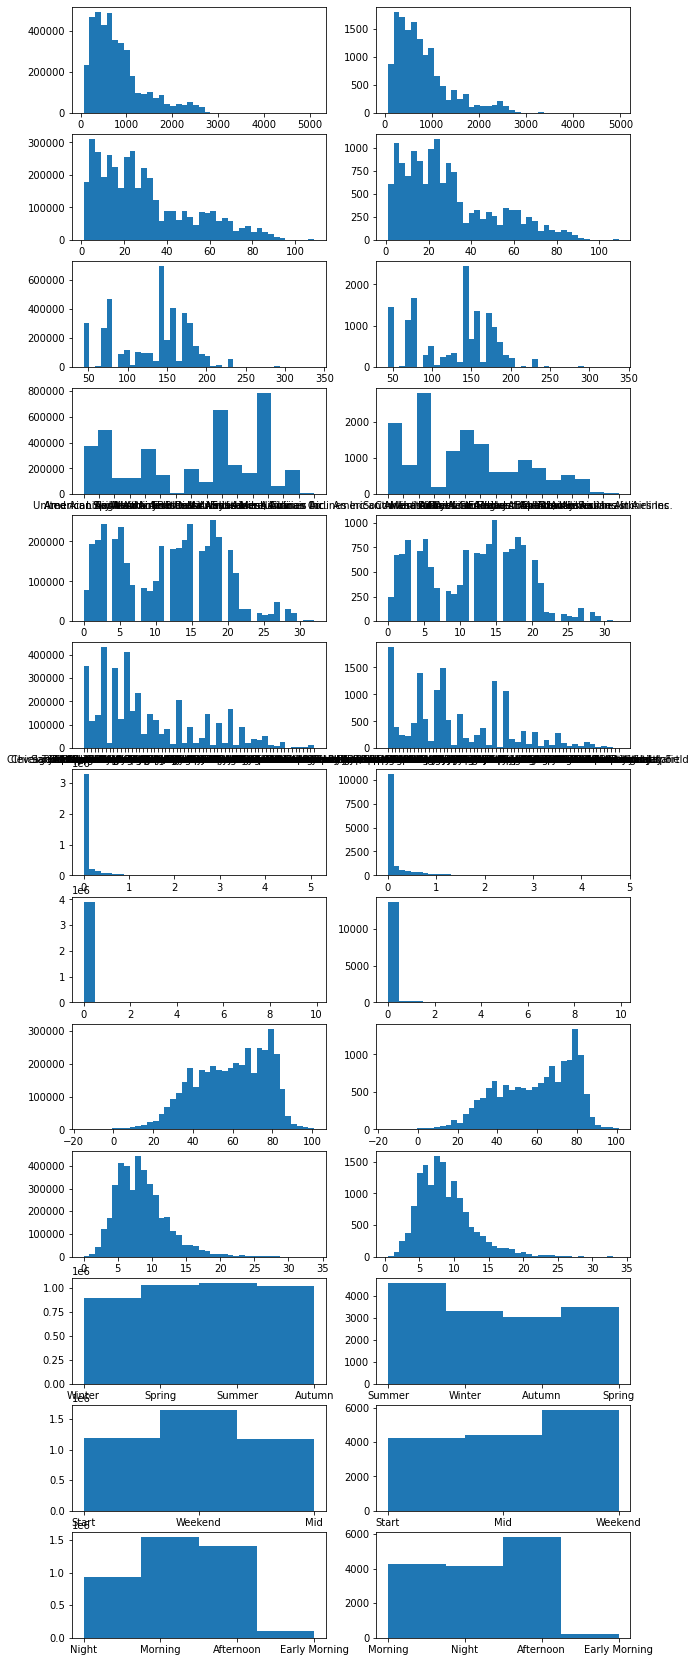

In [40]:
fig = plt.figure(figsize=(10,30))

fig.add_subplot(13, 2, 1).hist(combined_df['DISTANCE'], bins=40)
fig.add_subplot(13, 2, 2).hist(combined_final_df['DISTANCE'], bins=40)

fig.add_subplot(13, 2, 3).hist(combined_df['CONCURRENT_FLIGHTS'], bins=40)
fig.add_subplot(13, 2, 4).hist(combined_final_df['CONCURRENT_FLIGHTS'], bins=40)

fig.add_subplot(13, 2, 5).hist(combined_df['NUMBER_OF_SEATS'], bins=40)
fig.add_subplot(13, 2, 6).hist(combined_final_df['NUMBER_OF_SEATS'], bins=40)

fig.add_subplot(13, 2, 7).hist(combined_df['CARRIER_NAME'], bins=16)
fig.add_subplot(13, 2, 8).hist(combined_final_df['CARRIER_NAME'], bins=16)

fig.add_subplot(13, 2, 9).hist(combined_df['PLANE_AGE'], bins=40)
fig.add_subplot(13, 2, 10).hist(combined_final_df['PLANE_AGE'], bins=40)

fig.add_subplot(13, 2, 11).hist(combined_df['DEPARTING_AIRPORT'], bins=40)
fig.add_subplot(13, 2, 12).hist(combined_final_df['DEPARTING_AIRPORT'], bins=40)

fig.add_subplot(13, 2, 13).hist(combined_df['PRCP'], bins=40)
fig.add_subplot(13, 2, 14).hist(combined_final_df['PRCP'], bins=40)

fig.add_subplot(13, 2, 15).hist(combined_df['SNOW'], bins=20)
fig.add_subplot(13, 2, 16).hist(combined_final_df['SNOW'], bins=20)

fig.add_subplot(13, 2, 17).hist(combined_df['TAVG'], bins=40)
fig.add_subplot(13, 2, 18).hist(combined_final_df['TAVG'], bins=40)

fig.add_subplot(13, 2, 19).hist(combined_df['AWND'], bins=40)
fig.add_subplot(13, 2, 20).hist(combined_final_df['AWND'], bins=40)

fig.add_subplot(13, 2, 21).hist(combined_df['SEASON'], bins=4)
fig.add_subplot(13, 2, 22).hist(combined_final_df['SEASON'], bins=4)

fig.add_subplot(13, 2, 23).hist(combined_df['TIME_OF_WEEK'], bins=3)
fig.add_subplot(13, 2, 24).hist(combined_final_df['TIME_OF_WEEK'], bins=3)

fig.add_subplot(13, 2, 25).hist(combined_df['TIME_OF_DAY'], bins=4)
fig.add_subplot(13, 2, 26).hist(combined_final_df['TIME_OF_DAY'], bins=4)


### Normalizing numerical variables
The different numerical variables have different ranges, thus we normalize to prevent the learning rate of models from being largely determined by the feature with the largest range.

In [41]:
def normalize(x, max, min):
    return (x-min) / (max-min)

numeric_cols = ['DISTANCE', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'PRCP', 'SNOW', 'TAVG', 'AWND']
for col in numeric_cols:
    max, min = np.max(combined_final_df[col]), np.min(combined_final_df[col])
    # combined_final_df[col] = combined_final_df[col].apply(lambda val: combined_final_df(val, max, min))
    new_values = []
    for val in combined_final_df[col]:
        new_values.append((val - min) / (max - min))
    combined_final_df[col] = new_values

combined_final_df

,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,PLANE_AGE,DEPARTING_AIRPORT,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY,DELAY_CAT
110002,0.191624,0.527778,0.395904,American Airlines Inc.,0.25000,Chicago O'Hare International,0.000000,0.0,0.810345,0.234923,Summer,Start,Morning,0
35579,0.152605,0.250000,0.088737,Comair Inc.,0.53125,Philadelphia International,0.079665,0.0,0.439655,0.181218,Winter,Start,Morning,0
319697,0.061696,0.148148,0.337884,Southwest Airlines Co.,0.25000,Friendship International,0.000000,0.0,0.853448,0.140714,Summer,Start,Night,0
322282,0.160163,0.074074,0.109215,Mesa Airlines Inc.,0.06250,Savannah/Hilton Head International,0.058700,0.0,0.801724,0.127513,Summer,Start,Morning,0
225937,0.192850,0.138889,0.334471,United Air Lines Inc.,0.53125,Tampa International,0.000000,0.0,0.844828,0.342334,Autumn,Mid,Morning,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332629,0.096425,0.027778,0.259386,Alaska Airlines Inc.,0.59375,Anchorage International,0.000000,0.0,0.370690,0.066907,Spring,Start,Morning,4
165828,0.111338,0.574074,0.395904,American Airlines Inc.,0.18750,Chicago O'Hare International,0.067086,0.0,0.793103,0.228023,Summer,Start,Night,4
184307,0.111338,0.240741,0.395904,American Airlines Inc.,0.12500,Ronald Reagan Washington National,0.000000,0.0,0.706897,0.134113,Autumn,Weekend,Afternoon,4
299146,0.074362,0.092593,0.109215,"Midwest Airline, Inc.",0.18750,Raleigh-Durham International,0.000000,0.0,0.810345,0.073807,Summer,Weekend,Afternoon,4


### Label Encoding

In [47]:
# label encoding
label_enc = preprocessing.LabelEncoder()
cols = ["CARRIER_NAME", "DEPARTING_AIRPORT", "SEASON", "TIME_OF_WEEK", "TIME_OF_DAY"]
# combined_final_df[cols] = combined_final_df[cols].apply(label_enc.fit_transform)
new_col_names = []

### NEW
new_test_df = pd.DataFrame()
for col in cols:
    new_col = label_enc.fit_transform(combined_final_df[col])
    
    # print(label_enc.classes_)
    # print("\n")
    # print(len(new_col))
    # print("\n")

    for name in label_enc.classes_:
        new_col_names.append(name)
    
    combined_final_df[col] = new_col

In [51]:
# combined_final_df

### Splitting Dataset

In [52]:
#Split into train, test, validation sets
x = combined_final_df.drop(columns=['DELAY_CAT'], axis=1)
y = combined_final_df['DELAY_CAT']
X_train, X_left, y_train, y_left = train_test_split(x, y, train_size=0.6, random_state=105)
X_valid, X_test, y_valid, y_test = train_test_split(X_left,y_left, test_size=0.5, random_state=105)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(8688, 13)
(2896, 13)
(2896, 13)


In [53]:
X_train

,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,PLANE_AGE,DEPARTING_AIRPORT,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY
111555,0.181205,0.314815,0.300341,5,0.53125,52,0.044025,0.080808,0.448276,0.301830,1,0,2
93250,0.091522,0.629630,0.529010,5,0.59375,3,0.050314,0.000000,0.844828,0.221422,2,0,3
259835,0.023493,0.129630,0.075085,10,0.53125,60,0.138365,0.000000,0.706897,0.167717,2,0,0
138332,0.047804,0.222222,0.191126,9,0.43750,24,0.000000,0.000000,0.801724,0.241524,2,2,0
162207,0.083555,0.092593,0.109215,10,0.12500,22,0.000000,0.000000,0.784483,0.120612,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,0.069867,0.768519,0.109215,12,0.12500,9,0.000000,0.000000,0.698276,0.255026,2,2,3
103355,0.314198,0.546296,0.447099,13,0.03125,55,0.000000,0.000000,0.353448,0.389139,3,2,0
171039,0.231665,0.129630,0.375427,15,0.53125,10,0.090147,0.000000,0.672414,0.194419,2,2,2
148175,0.044331,0.194444,0.088737,11,0.43750,36,0.006289,0.000000,0.672414,0.255026,1,2,3


### Feature Selection

Categorical Feature Selection

In [54]:
cont_labels = ["DISTANCE", "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS", "PLANE_AGE", "PRCP", "SNOW", "TAVG", "AWND"]
cat_labels = ["CARRIER_NAME", "DEPARTING_AIRPORT", "SEASON", "TIME_OF_WEEK", "TIME_OF_DAY"]

cont_features_df = X_train[cont_labels]
cat_features_df = X_train[cat_labels]

In [55]:
mi_score = MIC(cat_features_df, y_train)

In [59]:
mi_score = pd.Series(mi_score)
mi_score.index = cat_features_df.columns
mi_score.sort_values(ascending=False)
mi_score

CARRIER_NAME         0.074980
DEPARTING_AIRPORT    0.054170
SEASON               0.019634
TIME_OF_WEEK         0.000000
TIME_OF_DAY          0.029626
dtype: float64

In [64]:
selected_cat_var = ["CARRIER_NAME", "DEPARTING_AIRPORT", "SEASON", "TIME_OF_DAY"]

Continuous Feature Selection

In [60]:
cont_features_df['delay_cat'] = y_train
corr_mat = cont_features_df.corr(method='kendall')
corr_mat['delay_cat'][:-1]

DISTANCE             -0.272719
CONCURRENT_FLIGHTS   -0.201576
NUMBER_OF_SEATS      -0.318888
PLANE_AGE            -0.204102
PRCP                 -0.063769
SNOW                 -0.207494
TAVG                 -0.149069
AWND                 -0.164700
Name: delay_cat, dtype: float64

In [61]:
new_corr = abs(corr_mat['delay_cat'][:-1]).sort_values(ascending=False)
new_corr

NUMBER_OF_SEATS       0.318888
DISTANCE              0.272719
SNOW                  0.207494
PLANE_AGE             0.204102
CONCURRENT_FLIGHTS    0.201576
AWND                  0.164700
TAVG                  0.149069
PRCP                  0.063769
Name: delay_cat, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

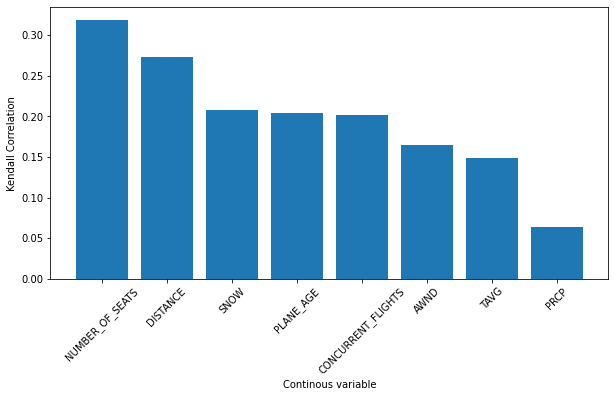

In [62]:
plt.figure(figsize=(10,5))
plt.bar(new_corr.index, new_corr.values)
plt.xlabel('Continous variable')
plt.ylabel('Kendall Correlation')
plt.xticks(rotation=45)

In [63]:
selected_numeric_var = list(new_corr[:5].index)
selected_numeric_var

['NUMBER_OF_SEATS', 'DISTANCE', 'SNOW', 'PLANE_AGE', 'CONCURRENT_FLIGHTS']

In [69]:
X_train

,DISTANCE,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,PLANE_AGE,DEPARTING_AIRPORT,PRCP,SNOW,TAVG,AWND,SEASON,TIME_OF_WEEK,TIME_OF_DAY
111555,0.181205,0.314815,0.300341,5,0.53125,52,0.044025,0.080808,0.448276,0.301830,1,0,2
93250,0.091522,0.629630,0.529010,5,0.59375,3,0.050314,0.000000,0.844828,0.221422,2,0,3
259835,0.023493,0.129630,0.075085,10,0.53125,60,0.138365,0.000000,0.706897,0.167717,2,0,0
138332,0.047804,0.222222,0.191126,9,0.43750,24,0.000000,0.000000,0.801724,0.241524,2,2,0
162207,0.083555,0.092593,0.109215,10,0.12500,22,0.000000,0.000000,0.784483,0.120612,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2972,0.069867,0.768519,0.109215,12,0.12500,9,0.000000,0.000000,0.698276,0.255026,2,2,3
103355,0.314198,0.546296,0.447099,13,0.03125,55,0.000000,0.000000,0.353448,0.389139,3,2,0
171039,0.231665,0.129630,0.375427,15,0.53125,10,0.090147,0.000000,0.672414,0.194419,2,2,2
148175,0.044331,0.194444,0.088737,11,0.43750,36,0.006289,0.000000,0.672414,0.255026,1,2,3


In [70]:
# Selecting chosen features from combined_final_df
final_cols = selected_numeric_var + selected_cat_var

final_train_df = X_train[final_cols]
final_valid_df = X_valid[final_cols]
final_test_df = X_test[final_cols]

final_train_df["DELAY_CAT"] = y_train
final_valid_df["DELAY_CAT"] = y_valid
final_test_df["DELAY_CAT"] = y_test


In [74]:
final_train_df.to_csv("processed_train_set.csv", index=False)
final_valid_df.to_csv("processed_valid_set.csv", index=False)
final_test_df.to_csv("processed_test_set.csv", index=False)

### One-hot encoding

In [148]:
# one-hot encoding
ohe_enc = OneHotEncoder(categories='auto')
categorical_train = ohe_enc.fit_transform(final_train_df[selected_cat_var])
train_feature_names = ohe_enc.get_feature_names()

categorical_val = ohe_enc.fit_transform(final_valid_df[selected_cat_var])
val_feature_names = ohe_enc.get_feature_names()

categorical_test = ohe_enc.fit_transform(final_test_df[selected_cat_var])
test_feature_names = ohe_enc.get_feature_names()

X_train_encoded_df = pd.DataFrame(categorical_train.toarray())
X_val_encoded_df = pd.DataFrame(categorical_val.toarray())
X_test_encoded_df = pd.DataFrame(categorical_test.toarray())

In [149]:
X_train_encoded_df

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [153]:
print(train_feature_names)
print(val_feature_names)
print(test_feature_names)

print("\n")

for item in train_feature_names:
    if item not in val_feature_names:
        print("present in train but absent in val:", item)

    if item not in test_feature_names:
        print("present in train but absent in test:", item)

print("\n")

for item in val_feature_names:
    if item not in train_feature_names:
        print("present in val but absent in train:", item)

    if item not in test_feature_names:
        print("present in val but absent in test:", item)

print("\n")

for item in test_feature_names:
    if item not in train_feature_names:
        print("present in test but absent in train:", item)

    if item not in val_feature_names:
        print("present in test but absent in val:", item)

print("\n")

print("Train needs: x1_30")
print("Val needs: x1_38")
print("Test needs: x1_30, x1_43")

print("\n")
# selected_cat_var = ["CARRIER_NAME", "DEPARTING_AIRPORT", "SEASON", "TIME_OF_DAY"]
carrier_name_list = new_col_names[:16]
departing_airport_list = new_col_names[16:79]
season_list = new_col_names[79:83]
time_of_day_list = new_col_names[86:90]
selected_cat_col_names = carrier_name_list + departing_airport_list + season_list + time_of_day_list

['x0_0' 'x0_1' 'x0_2' 'x0_3' 'x0_4' 'x0_5' 'x0_6' 'x0_7' 'x0_8' 'x0_9'
 'x0_10' 'x0_11' 'x0_12' 'x0_13' 'x0_14' 'x0_15' 'x1_0' 'x1_1' 'x1_2'
 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7' 'x1_8' 'x1_9' 'x1_10' 'x1_11' 'x1_12'
 'x1_13' 'x1_14' 'x1_15' 'x1_16' 'x1_17' 'x1_18' 'x1_19' 'x1_20' 'x1_21'
 'x1_22' 'x1_23' 'x1_24' 'x1_25' 'x1_26' 'x1_27' 'x1_28' 'x1_29' 'x1_31'
 'x1_32' 'x1_33' 'x1_34' 'x1_35' 'x1_36' 'x1_37' 'x1_38' 'x1_39' 'x1_40'
 'x1_41' 'x1_42' 'x1_43' 'x1_44' 'x1_45' 'x1_46' 'x1_47' 'x1_48' 'x1_49'
 'x1_50' 'x1_51' 'x1_52' 'x1_53' 'x1_54' 'x1_55' 'x1_56' 'x1_57' 'x1_58'
 'x1_59' 'x1_60' 'x1_61' 'x1_62' 'x2_0' 'x2_1' 'x2_2' 'x2_3' 'x3_0' 'x3_1'
 'x3_2' 'x3_3']
['x0_0' 'x0_1' 'x0_2' 'x0_3' 'x0_4' 'x0_5' 'x0_6' 'x0_7' 'x0_8' 'x0_9'
 'x0_10' 'x0_11' 'x0_12' 'x0_13' 'x0_14' 'x0_15' 'x1_0' 'x1_1' 'x1_2'
 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7' 'x1_8' 'x1_9' 'x1_10' 'x1_11' 'x1_12'
 'x1_13' 'x1_14' 'x1_15' 'x1_16' 'x1_17' 'x1_18' 'x1_19' 'x1_20' 'x1_21'
 'x1_22' 'x1_23' 'x1_24' 'x1_25' 'x1_26' 

86

In [151]:
# train
zero_col = []
for num in range(len(X_train_encoded_df.index)):
    zero_col.append(0)

left_split_list = list(range(46))
right_split_list = list(range(46, len(X_train_encoded_df.columns)))

X_train_left_split = X_train_encoded_df[left_split_list]
X_train_left_split[46] = zero_col

X_train_right_split = X_train_encoded_df[right_split_list]

X_train_encoded_df = pd.DataFrame(np.hstack(
    (X_train[selected_numeric_var],
    X_train_left_split,
    X_train_right_split)
))


In [156]:
# val
zero_col = []
for num in range(len(X_val_encoded_df.index)):
    zero_col.append(0)

left_split_list = list(range(54))
right_split_list = list(range(54, len(X_val_encoded_df.columns)))

X_val_left_split = X_val_encoded_df[left_split_list]
X_val_left_split[54] = zero_col

X_val_right_split = X_val_encoded_df[right_split_list]

X_val_encoded_df = pd.DataFrame(np.hstack(
    (X_valid[selected_numeric_var],
    X_val_left_split,
    X_val_right_split)
))

In [158]:
# test
zero_col = []
for num in range(len(X_test_encoded_df.index)):
    zero_col.append(0)

left_split_list = list(range(46))
mid_split_list = list(range(46, 58))
right_split_list = list(range(58, len(X_test_encoded_df.columns)))

X_test_left_split = X_test_encoded_df[left_split_list]
X_test_left_split[46] = zero_col

X_test_mid_split = X_test_encoded_df[mid_split_list]
X_test_mid_split[58] = zero_col

X_test_right_split = X_test_encoded_df[right_split_list]

X_test_encoded_df = pd.DataFrame(np.hstack(
    (X_test[selected_numeric_var],
    X_test_left_split,
    X_test_mid_split,
    X_test_right_split)
))

In [163]:
selected_feature_names = selected_numeric_var + selected_cat_col_names

feature_names_dict = {}
for num in range(len(selected_feature_names)):
    feature_names_dict[num] = selected_feature_names[num]

for df in [X_train_encoded_df, X_val_encoded_df, X_test_encoded_df]:
    df.rename(columns=feature_names_dict, inplace=True)

In [166]:
X_test_encoded_df

,NUMBER_OF_SEATS,DISTANCE,SNOW,PLANE_AGE,CONCURRENT_FLIGHTS,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Comair Inc.,...,Will Rogers World,William P Hobby,Autumn,Spring,Summer,Winter,Afternoon,Early Morning,Morning,Night
0,0.088737,0.054750,0.000000,0.53125,0.407407,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.300341,0.457406,0.000000,0.56250,0.046296,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.109215,0.111338,0.000000,0.34375,0.101852,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.337884,0.195506,0.000000,0.56250,0.296296,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.286689,0.107661,0.000000,0.62500,0.166667,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2891,0.440273,0.344637,0.000000,0.21875,0.212963,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2892,0.484642,0.218386,0.000000,0.03125,0.111111,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2893,0.109215,0.139122,0.000000,0.06250,0.240741,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2894,0.088737,0.069663,0.000000,0.46875,0.240741,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [168]:
X_train_encoded_df.to_excel("X_train_encoded.xlsx", index=False)
y_train.to_excel("Y_train.xlsx", index=False)

X_val_encoded_df.to_excel("X_val_encoded.xlsx", index=False)
y_valid.to_excel("Y_val.xlsx", index=False)

X_test_encoded_df.to_excel("X_test_encoded.xlsx", index=False)
y_test.to_excel("Y_test.xlsx", index=False)